Copyright © Agilesh Arumugam

We attempt to make a simple chatbot like old Siri / Google Assistant.

# Imports

In [1]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
import sentence_transformers as st
import numpy as np
from typing import List
import os
import json
import torch
import torchvision
import torchaudio
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

print("Sentence Transformer: ", st.__version__)
print("Numpy:", np.__version__)
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("Torchaudio:", torchaudio.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version (from torch):", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

Sentence Transformer:  5.0.0
Numpy: 2.0.1
PyTorch: 2.5.1
Torchvision: 0.20.1
Torchaudio: 2.5.1
CUDA available: True
CUDA version (from torch): 11.8
cuDNN version: 90100


# VectorDB Class

We make a simple Vector DB class that manages the vector representation of prompts from our dataset.

In [2]:
class VectorDB:
    def __init__(self, path=""):
        self.transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.path = path
        self.similarity_checking_model = CrossEncoder('cross-encoder/stsb-roberta-base')
        os.makedirs(self.path, exist_ok=True)
        
        self.meta_path = os.path.join(self.path, "meta.txt")
        self.clear()

    def add_vector(self, text: str):
        text = text.strip()
    
        with open(self.meta_path, "r", encoding="utf-8") as f:
            for line in f:
                if line.strip() == text:
                    return

        with open(self.meta_path, "a", encoding="utf-8") as f_meta:
            f_meta.write(text + "\n")

    def get_most_similar(self, text):
        most_similar_text = None
        max_similarity = float('-inf')
    
        with open(self.meta_path, "r", encoding="utf-8") as f:
            for line in f:
                candidate = line.strip()
                if not candidate:
                    continue
                score = self.similarity_checking_model.predict([(text, candidate)])[0]
                if score > max_similarity:
                    max_similarity = score
                    most_similar_text = candidate
    
        if most_similar_text is not None:
            return most_similar_text, max_similarity
        return None

    def clear(self):
        if os.path.exists(self.meta_path):
            os.remove(self.meta_path)
        open(self.meta_path, "a").close()

Sample code showing how to use the VectorDB class.

In [3]:
vector_db = VectorDB("VectorDB")

In [4]:
vector_db.add_vector("How to cook noodles?")
vector_db.add_vector("Hello World!")
vector_db.add_vector("How to cook pasta?")
print(vector_db.get_most_similar("How the FUCK do I cook spaghetti?"))

('How to cook noodles?', np.float32(0.84038234))


# Dataset Class

We make a dataset class so we can efficiently query questions for their answers, rather than having the entire dataset in memory.

In [5]:
class AgiDataset:
    def __init__(self, path: str):
        if os.path.exists(path):
            self.path = path
        else:
            raise Exception("That path doesn't exist!")
        if not path.endswith(".jsonl"):
            raise Exception("AgiDataset class instantiation needs a path to a .jsonl file.")
            
    def get_answer_for(self, question):
        with open(self.path, "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                if obj["user"] == question:
                    return obj["assistant"]
        return None
    
    def add_questions_to_vector_db(self, vector_db: VectorDB):
        with open(self.path, "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                vector_db.add_vector(obj["user"])

Sample code showing how to use the AgiDataset class.

In [6]:
dataset = AgiDataset("data/data.jsonl")

In [7]:
vector_db.clear()
dataset.add_questions_to_vector_db(vector_db)

# Pipeline

We now see how we shall go about responding to actual requests.

In [8]:
# assume a request as follows:
user_request = "I want to pay my exam fees, how do I do it?"

# first we get the most similar question that already exists in the database
most_similar_string, similarity = vector_db.get_most_similar(user_request)
print(f"Most similar question in database: {most_similar_string}, with similarity of {similarity}.")

# then we get the answer for the question from the dataset
answer = dataset.get_answer_for(most_similar_string)
print(f"Answer for the request is: {answer}")

Most similar question in database: Where do I pay my exam fees?, with similarity of 0.7649897336959839.
Answer for the request is: Login to your student portal (https://sp.srmist.edu.in/srmiststudentportal/students/loginManager/youLogin.jsp) and click “Fee Payment” and click “Fee Details”. There you can see how much exam fees or fees in general you have to pay.


So we define the following function. 

In [9]:
def get_answer_for(request, vector_db, dataset):
    most_similar_string, similarity = vector_db.get_most_similar(request)
    if similarity < 0.5:
        return "I can't answer that.", similarity
    return dataset.get_answer_for(most_similar_string), similarity

In [10]:
answer, similarity = get_answer_for("I want to see my exam timetable?", vector_db, dataset)
print(answer, similarity)

Login to your student portal (https://sp.srmist.edu.in/srmiststudentportal/students/loginManager/youLogin.jsp) and click “Scribe Request” on the left. Choose the month and year of your exams. There you can see the dates of your examinations. 0.7891468


# Hybrid Score Calculation

Since a query can be answered with two or more questions in the database, we want to be able to see which answers fit the queston, while simultaneously filtering out the answers that *seem* like they should fit the question but actually don't.

This is why we will be making a new formula for calculating score, i.e.,
```
score = semantic_similarity * normalize(cosine_similarity)
```

Thus, we need to redefine the vector DB class.

In [11]:
def normalize_cosine_similarity(cos_sim):
    return 0.5 * cos_sim + 0.5

In [12]:
def get_most_similar_with_hybrid_score(self, text):
    most_similar_text = None
    max_similarity = float('-inf')

    with open(self.meta_path, "r", encoding="utf-8") as f:
        for line in f:
            candidate = line.strip()
            if not candidate:
                continue
            semantic_similarity = self.similarity_checking_model.predict([(text, candidate)])[0]
            cos_sim = cosine_similarity([self.transformer_model.encode(text)], [self.transformer_model.encode(candidate)])[0][0]
            normalized_cos_sim = normalize_cosine_similarity(cos_sim)
            score = semantic_similarity * normalized_cos_sim
            if score > max_similarity:
                max_similarity = score
                most_similar_text = candidate

    if most_similar_text is not None:
        return most_similar_text, max_similarity
    return None

VectorDB.get_most_similar_with_hybrid_score = get_most_similar_with_hybrid_score

In [13]:
vector_db.clear()
dataset.add_questions_to_vector_db(vector_db)

In [14]:
most_similar_string, similarity = vector_db.get_most_similar_with_hybrid_score("I want to see my exam timetable.")
print(most_similar_string, similarity)
most_similar_string, similarity = vector_db.get_most_similar("I want to see my exam timetable.")
print(most_similar_string, similarity)

Where do I see my exam timetable? 0.69562966
Where do I see my exam timetable? 0.72011346


Let us see how the other strings match with the input string by visualizing their scores.

In [15]:
def get_all_scores(self, text):
    scores = []
    with open(self.meta_path, "r", encoding="utf-8") as f:
        for line in f:
            candidate = line.strip()
            if not candidate:
                continue
            semantic_similarity = self.similarity_checking_model.predict([(text, candidate)])[0]
            cos_sim = cosine_similarity([self.transformer_model.encode(text)], [self.transformer_model.encode(candidate)])[0][0]
            normalized_cos_sim = normalize_cosine_similarity(cos_sim)
            score = semantic_similarity * normalized_cos_sim
            scores.append(score)
    scores.sort(reverse=True)
    return scores

VectorDB.get_all_scores = get_all_scores

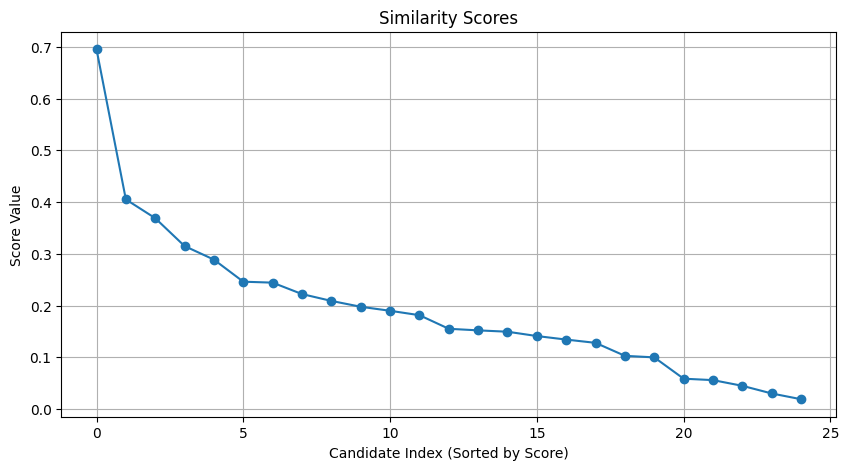

In [16]:
scores = vector_db.get_all_scores("I want to see my exam timetable.")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o')
plt.title("Similarity Scores")
plt.xlabel("Candidate Index (Sorted by Score)")
plt.ylabel("Score Value")
plt.grid(True)
plt.show()

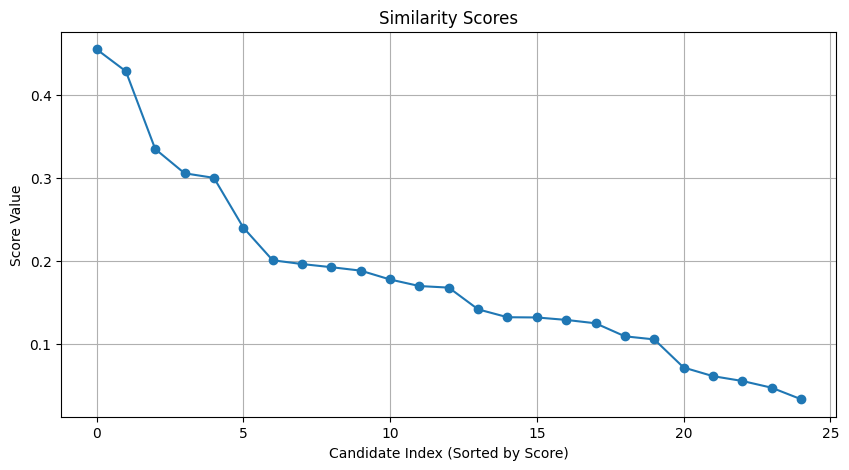

In [23]:
scores = vector_db.get_all_scores("I want to see my exam timetable. I want to pay my exam fees.")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o')
plt.title("Similarity Scores")
plt.xlabel("Candidate Index (Sorted by Score)")
plt.ylabel("Score Value")
plt.grid(True)
plt.show()

We observe that if a question is a kind of superset of two questions that already exist in the database, then their similarity scores lie to the left of the first point of inflection (point where rate of change of slope = 0), or the knee of the curve.

Therefore for questions that combine two or more questions, we return the answers for whichever question from the has a similarity score that lies to the left of the point of inflection or knee of the curve.

We define a new function to find the point of inflection for us.

In [18]:
def find_point_of_inflection(data):
    data.sort(reverse=True)
    data = np.array(data)
    first_derivative = np.diff(data)
    second_derivative = np.diff(first_derivative)

    # inflection = where second derivative changes sign from negative to positive
    for i in range(1, len(second_derivative)):
        if second_derivative[i - 1] < 0 and second_derivative[i] > 0:
            return (i + 1, data[i + 1])  # +1 to offset diff offset

    return None

def find_point_of_knee(data):
    from kneed import KneeLocator
    x = list(range(len(data)))
    kl = KneeLocator(x, data, curve='convex', direction='decreasing')
    return kl.knee, data[kl.knee]

def get_threshold(data):
    inflection_poinf_idx, inflection_point = find_point_of_inflection(data)
    knee_idx, knee = find_point_of_knee(data)
    if knee_idx < inflection_poinf_idx:
        return knee_idx, knee
    return inflection_poinf_idx, inflection_point

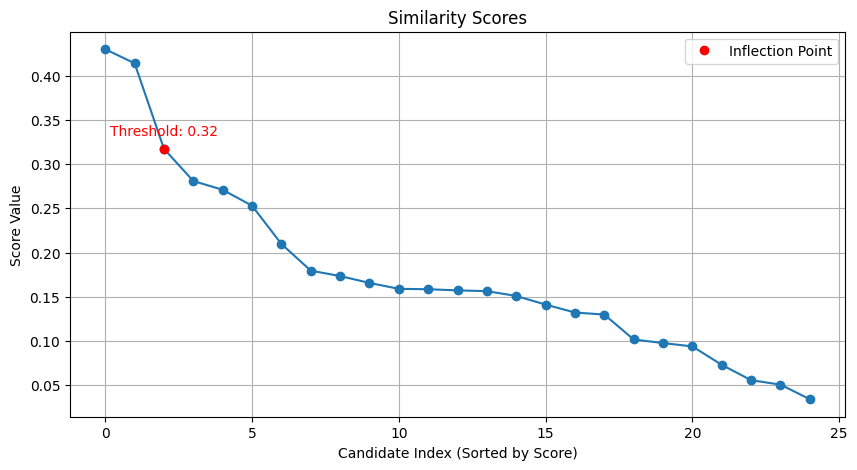

In [19]:
scores = vector_db.get_all_scores("I want to see my exam time table. I want to pay my exam fees.")
threshold_idx, threshold = get_threshold(scores)
plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o')
plt.plot(threshold_idx, threshold, 'ro', label='Inflection Point')
plt.annotate(f"Threshold: {threshold:.2f}",
             (threshold_idx, threshold),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.title("Similarity Scores")
plt.xlabel("Candidate Index (Sorted by Score)")
plt.ylabel("Score Value")
plt.grid(True)
plt.legend()
plt.show()

So all questions with similarity scores less than the found threshold's answers will be considered to return.

In [40]:
def get_all_sentence_greater_than_threshold(self, text, threshold):
    questions = []
    with open(self.meta_path, "r", encoding="utf-8") as f:
        for line in f:
            candidate = line.strip()
            if not candidate:
                continue
            semantic_similarity = self.similarity_checking_model.predict([(text, candidate)])[0]
            cos_sim = cosine_similarity([self.transformer_model.encode(text)], [self.transformer_model.encode(candidate)])[0][0]
            normalized_cos_sim = normalize_cosine_similarity(cos_sim)
            score = semantic_similarity * normalized_cos_sim
            if score > threshold and score > 0.25: # 0.25 is E[cosine_similarity, semantic_similarity]
                questions.append(candidate)

    return questions

VectorDB.get_all_sentence_greater_than_threshold = get_all_sentence_greater_than_threshold

In [41]:
scores = vector_db.get_all_scores("I want to see my exam time table. I want to pay my exam fees.")
threshold_idx, threshold = get_threshold(scores)
print(vector_db.get_all_sentence_greater_than_threshold("I want to see my exam timetable, I want to pay my exam fees.", threshold))

['Where do I see my exam timetable?', 'Where do I pay my exam fees?']


# Revised Pipeline

In [42]:
user_request = "Exam fees."

scores = vector_db.get_all_scores(user_request)
idx, threshold = get_threshold(scores)
questions = vector_db.get_all_sentence_greater_than_threshold(user_request, threshold)

result_string = ""
for question in questions:
    result_string = result_string + "Q: " + question + "\n"
    result_string = result_string + "A: " + dataset.get_answer_for(question) + "\n\n"

print(result_string)

Q: How do I get my exam hall ticket?
A: Login to your student portal (https://sp.srmist.edu.in/srmiststudentportal/students/loginManager/youLogin.jsp) and click “Exam Hall Ticket” on the left. If you see no exam hall ticket, wait for a faculty to respond or wait a couple of days.

Q: Where do I pay my exam fees?
A: Login to your student portal (https://sp.srmist.edu.in/srmiststudentportal/students/loginManager/youLogin.jsp) and click “Fee Payment” and click “Fee Details”. There you can see how much exam fees or fees in general you have to pay.


